# Prediksi Risiko Stroke

### Nama    : [Isi Nama Anda]
### NIM     : [Isi NIM Anda]
----------------------------------------------------------------
### Ringkasan/Permasalahan Project dan Tujuan yang Akan Dicapai
#### Permasalahan: 
Dataset ini berisi data demografis dan kesehatan dari ribuan pasien. Stroke merupakan penyebab kematian dan kecacatan yang serius, dan prediksi dini sangat penting. Tantangannya adalah membangun model yang dapat mengidentifikasi individu dengan risiko tinggi terkena stroke berdasarkan atribut seperti usia, riwayat penyakit (hipertensi, penyakit jantung), gaya hidup (merokok), dan data klinis (kadar glukosa, BMI). Dataset ini juga memiliki tantangan ketidakseimbangan kelas (class imbalance), di mana jumlah pasien yang mengalami stroke jauh lebih sedikit daripada yang tidak.

#### Tujuan: 
Membangun dan mengevaluasi beberapa model klasifikasi (seperti Logistic Regression, Random Forest, dan XGBoost) untuk memprediksi kemungkinan seseorang mengalami stroke. Tujuan utamanya adalah menciptakan model yang tidak hanya akurat secara keseluruhan tetapi juga memiliki performa baik dalam mendeteksi kasus stroke (kelas minoritas), yang akan diukur menggunakan metrik seperti F1-Score dan AUC-ROC. Model ini berpotensi menjadi alat bantu skrining awal bagi tenaga medis.

----------------------------------------------------------------
### Dataset: Kaggle Stroke Prediction Dataset
- **Sumber**: [Kaggle Dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)
- **Total Data**: 5110 sampel
- **Fitur**: 11 fitur (numerik dan kategorikal), tidak termasuk ID
- **Target**: `stroke` (1: ya, 0: tidak)

### Kategori Fitur:
1. **Demografis**: `gender`, `age`, `ever_married`, `Residence_type`
2. **Riwayat Medis**: `hypertension`, `heart_disease`
3. **Gaya Hidup**: `work_type`, `smoking_status`
4. **Data Klinis**: `avg_glucose_level`, `bmi`

In [1]:
# Import library dasar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import library untuk preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Import algoritma machine learning (Klasifikasi)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import xgboost as xgb

# Import untuk evaluasi model (Klasifikasi)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

# Setting untuk visualisasi
# Menggunakan style yang kompatibel dengan versi Matplotlib yang lebih baru
plt.style.use('seaborn-v0_8-whitegrid') 
sns.set_palette("viridis")
%matplotlib inline

print("✅ Semua library berhasil diimpor!")

✅ Semua library berhasil diimpor!


## 2. Membaca Dataset

In [2]:
# Load dataset dari path lokal
file_path = "dataset/healthcare-dataset-stroke-data.csv"

print("📥 Loading dataset dari path lokal...")

# Load data
df = pd.read_csv(file_path)
print(f"✅ Data loaded: {df.shape}")

print(f"\n📊 Dataset: Stroke Prediction Dataset")
print(f"🏠 Total samples: {len(df):,}")
print(f"📋 Total fitur: {len(df.columns)} (termasuk ID)")
print(f"🎯 Target: stroke")

📥 Loading dataset dari path lokal...
✅ Data loaded: (5110, 12)

📊 Dataset: Stroke Prediction Dataset
🏠 Total samples: 5,110
📋 Total fitur: 12 (termasuk ID)
🎯 Target: stroke


## 3. Exploratory Data Analysis (EDA)

In [3]:
# Informasi dasar dataset
print("=== INFORMASI DASAR DATASET ===")
df.info()

print("\n=== STATISTIK DESKRIPTIF (FITUR NUMERIK) ===")
display(df.describe())

print("\n=== JUMLAH NILAI KOSONG ===")
print(df.isnull().sum())

=== INFORMASI DASAR DATASET ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB

=== STATISTIK DESKRIPTIF (FITUR NUMERIK) ===


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000



=== JUMLAH NILAI KOSONG ===
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [4]:
# Preview data
print("=== PREVIEW DATA ===")
display(df.head())

=== PREVIEW DATA ===


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


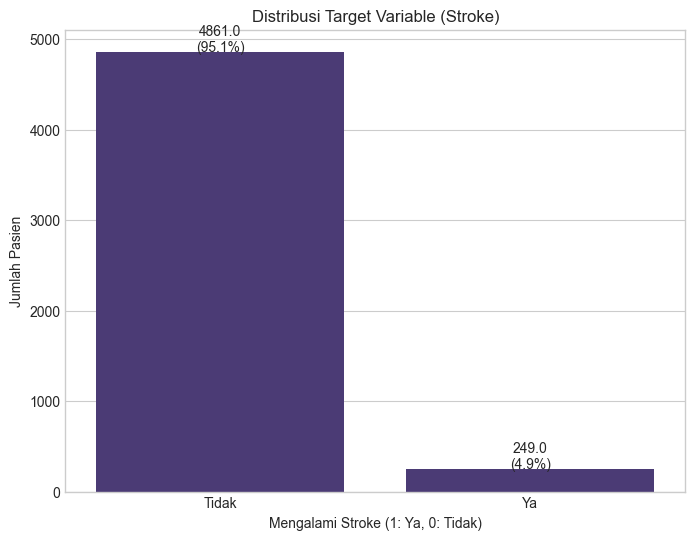

Insight: Dataset sangat tidak seimbang (imbalanced), dengan hanya 4.9% kasus stroke. Ini perlu ditangani dalam preprocessing.


In [5]:
# Analisis target variable (stroke)
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='stroke', data=df)
plt.title('Distribusi Target Variable (Stroke)')
plt.xlabel('Mengalami Stroke (1: Ya, 0: Tidak)')
plt.ylabel('Jumlah Pasien')
plt.xticks([0, 1], ['Tidak', 'Ya'])

for p in ax.patches:
    ax.annotate(f'{p.get_height()}\n({p.get_height()/len(df)*100:.1f}%)',
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9),
                textcoords = 'offset points')
plt.show()

print("Insight: Dataset sangat tidak seimbang (imbalanced), dengan hanya 4.9% kasus stroke. Ini perlu ditangani dalam preprocessing.")

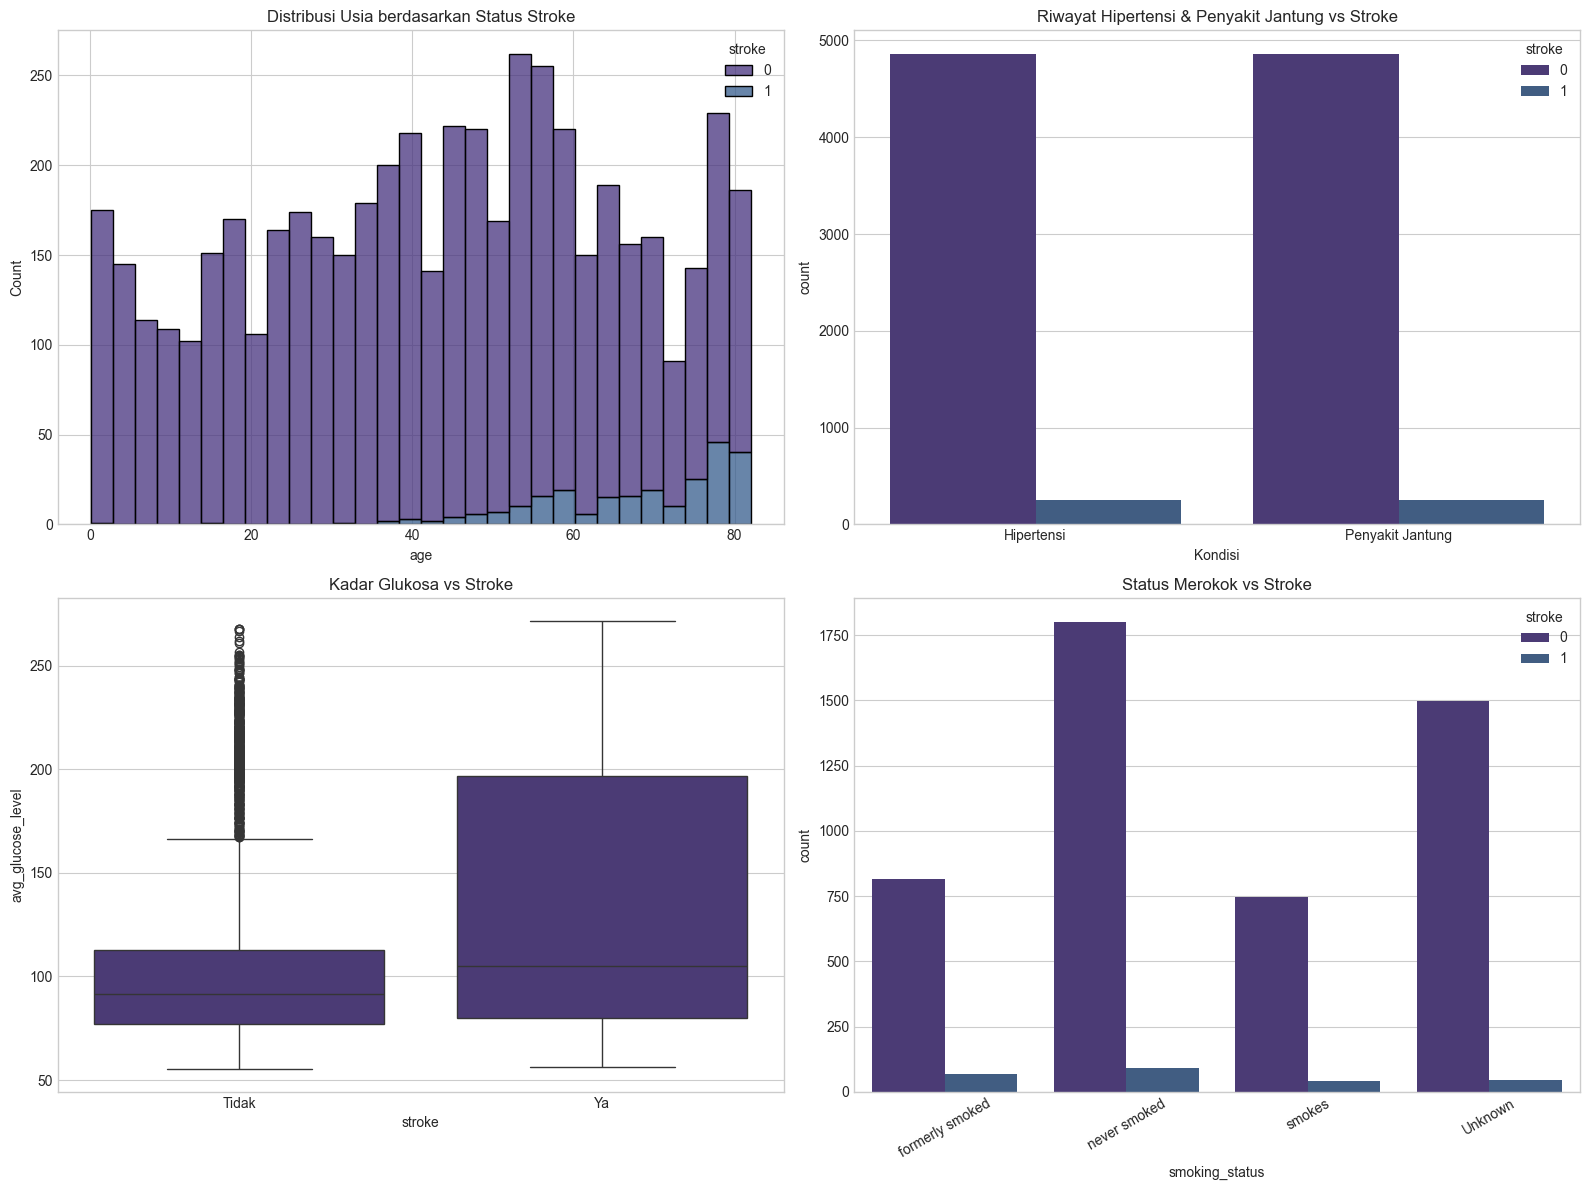

In [6]:
# Analisis fitur penting
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribusi Usia vs Stroke
sns.histplot(data=df, x='age', hue='stroke', multiple='stack', ax=axes[0, 0], bins=30)
axes[0, 0].set_title('Distribusi Usia berdasarkan Status Stroke')

# 2. Hubungan Hipertensi & Penyakit Jantung dengan Stroke
df_hyper_heart = df.melt(id_vars=['stroke'], value_vars=['hypertension', 'heart_disease'], var_name='Kondisi')
sns.countplot(data=df_hyper_heart, x='Kondisi', hue='stroke', ax=axes[0, 1])
axes[0, 1].set_title('Riwayat Hipertensi & Penyakit Jantung vs Stroke')
axes[0, 1].set_xticklabels(['Hipertensi', 'Penyakit Jantung'])

# 3. Rata-rata Kadar Glukosa vs Stroke
sns.boxplot(data=df, x='stroke', y='avg_glucose_level', ax=axes[1, 0])
axes[1, 0].set_title('Kadar Glukosa vs Stroke')
axes[1, 0].set_xticklabels(['Tidak', 'Ya'])

# 4. Status Merokok vs Stroke
sns.countplot(data=df, x='smoking_status', hue='stroke', ax=axes[1, 1])
axes[1, 1].set_title('Status Merokok vs Stroke')
axes[1, 1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

## 4. Data Preprocessing

In [7]:
# 1. Drop kolom ID karena tidak relevan
df = df.drop('id', axis=1)
print("Kolom 'id' dihapus.")

# 2. Handle missing values (BMI)
df['bmi'] = pd.to_numeric(df['bmi'], errors='coerce')
bmi_median = df['bmi'].median()
df['bmi'].fillna(bmi_median, inplace=True)
print(f"Missing values di 'bmi' diisi dengan median: {bmi_median:.2f}")

# 3. Handle 'Other' gender (hanya ada 1 sampel)
df = df[df['gender'] != 'Other']
print("Sampel dengan gender 'Other' dihapus.")

# 4. Encoding fitur kategorikal
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print("Fitur kategorikal di-encode menggunakan One-Hot Encoding.")

# 5. Pisahkan fitur (X) dan target (y)
X = df_encoded.drop('stroke', axis=1)
y = df_encoded['stroke']

# 6. Split data menjadi training dan testing set (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Data dibagi menjadi training dan testing set.")

# 7. Feature Scaling (hanya pada fitur numerik)
numerical_cols = ['age', 'avg_glucose_level', 'bmi']
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])
print("Fitur numerik di-scaling menggunakan StandardScaler.")

# 8. Handle class imbalance dengan SMOTE (hanya pada data training)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Class imbalance pada data training ditangani dengan SMOTE.")

print("\n✅ Data preprocessing selesai!")
print(f"Shape X_train original: {X_train.shape}")
print(f"Shape X_train resampled: {X_train_resampled.shape}")
print(f"Distribusi target di training set setelah SMOTE:\n{y_train_resampled.value_counts()}")

Kolom 'id' dihapus.
Missing values di 'bmi' diisi dengan median: 28.10
Sampel dengan gender 'Other' dihapus.
Fitur kategorikal di-encode menggunakan One-Hot Encoding.
Data dibagi menjadi training dan testing set.
Fitur numerik di-scaling menggunakan StandardScaler.
Class imbalance pada data training ditangani dengan SMOTE.

✅ Data preprocessing selesai!
Shape X_train original: (4087, 15)
Shape X_train resampled: (7776, 15)
Distribusi target di training set setelah SMOTE:
stroke
0    3888
1    3888
Name: count, dtype: int64


## 5. Model Training & Evaluation

In [8]:
# Inisialisasi model
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'SVC': SVC(probability=True, random_state=42)
}

# Dictionary untuk menyimpan hasil
results = {}

print("=== TRAINING MODELS ===")
for name, model in models.items():
    print(f"Training {name}...", end=" ")
    
    # Training model pada data yang sudah di-resample
    model.fit(X_train_resampled, y_train_resampled)
    
    # Prediksi pada test set
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Hitung metrik evaluasi
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    auc = roc_auc_score(y_test, y_proba)
    
    results[name] = {
        'Accuracy': accuracy,
        'F1-Score (1)': report['1']['f1-score'],
        'AUC': auc,
        'Model': model
    }
    
    print(f"✅ F1-Score: {report['1']['f1-score']:.4f}")

print("\n🎉 Training selesai!")

=== TRAINING MODELS ===
Training Logistic Regression... ✅ F1-Score: 0.2327
Training Decision Tree... ✅ F1-Score: 0.1656
Training Random Forest... ✅ F1-Score: 0.1690
Training Gradient Boosting... ✅ F1-Score: 0.2069
Training XGBoost... ✅ F1-Score: 0.1832
Training SVC... ✅ F1-Score: 0.1933

🎉 Training selesai!


In [9]:
# Evaluasi dan ranking model
results_df = pd.DataFrame({k: {metric: v[metric] for metric in ['Accuracy', 'F1-Score (1)', 'AUC']} for k, v in results.items()}).T
results_df = results_df.sort_values('F1-Score (1)', ascending=False)

print("=== HASIL EVALUASI MODEL ===")
print(f"{'Rank':<4} {'Model':<20} {'Accuracy':<10} {'F1-Score (1)':<15} {'AUC':<8}")
print("-" * 68)

for i, (model_name, row) in enumerate(results_df.iterrows(), 1):
    print(f"{i:<4} {model_name:<20} {row['Accuracy']:.4f}     {row['F1-Score (1)']:.4f}         {row['AUC']:.4f}")

# Model terbaik
best_model_name = results_df.index[0]
best_f1 = results_df.loc[best_model_name, 'F1-Score (1)']
best_auc = results_df.loc[best_model_name, 'AUC']

print(f"\n🏆 MODEL TERBAIK: {best_model_name}")
print(f"📊 F1-Score (Stroke): {best_f1:.4f}")
print(f"📊 AUC Score: {best_auc:.4f}")

=== HASIL EVALUASI MODEL ===
Rank Model                Accuracy   F1-Score (1)    AUC     
--------------------------------------------------------------------
1    Logistic Regression  0.7613     0.2327         0.8225
2    Gradient Boosting    0.7750     0.2069         0.7967
3    SVC                  0.7877     0.1933         0.7628
4    XGBoost              0.8953     0.1832         0.7646
5    Random Forest        0.8845     0.1690         0.7510
6    Decision Tree        0.8718     0.1656         0.5816

🏆 MODEL TERBAIK: Logistic Regression
📊 F1-Score (Stroke): 0.2327
📊 AUC Score: 0.8225


## 6. Comprehensive Visualization & Analysis

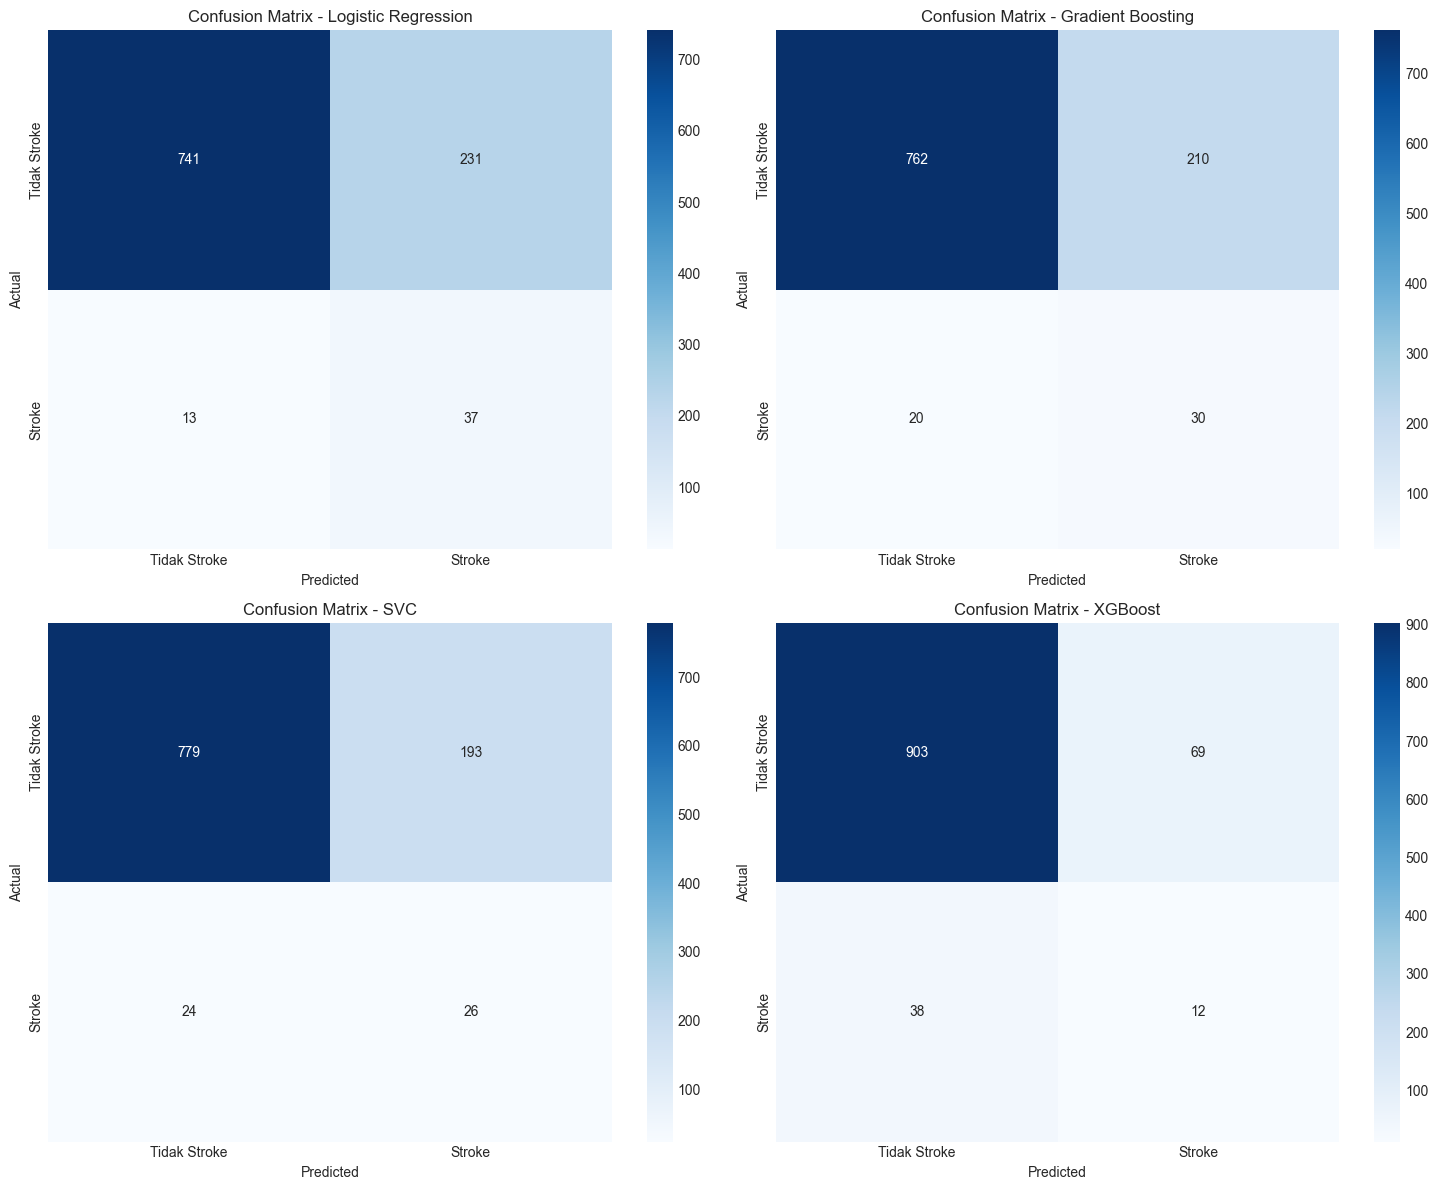

In [10]:
# Visualisasi komprehensif hasil
top_4_models = results_df.head(4).index

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

# 1. Confusion Matrix untuk 4 model terbaik
for i, model_name in enumerate(top_4_models):
    model = results[model_name]['Model']
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Tidak Stroke', 'Stroke'],
                yticklabels=['Tidak Stroke', 'Stroke'])
    axes[i].set_title(f'Confusion Matrix - {model_name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

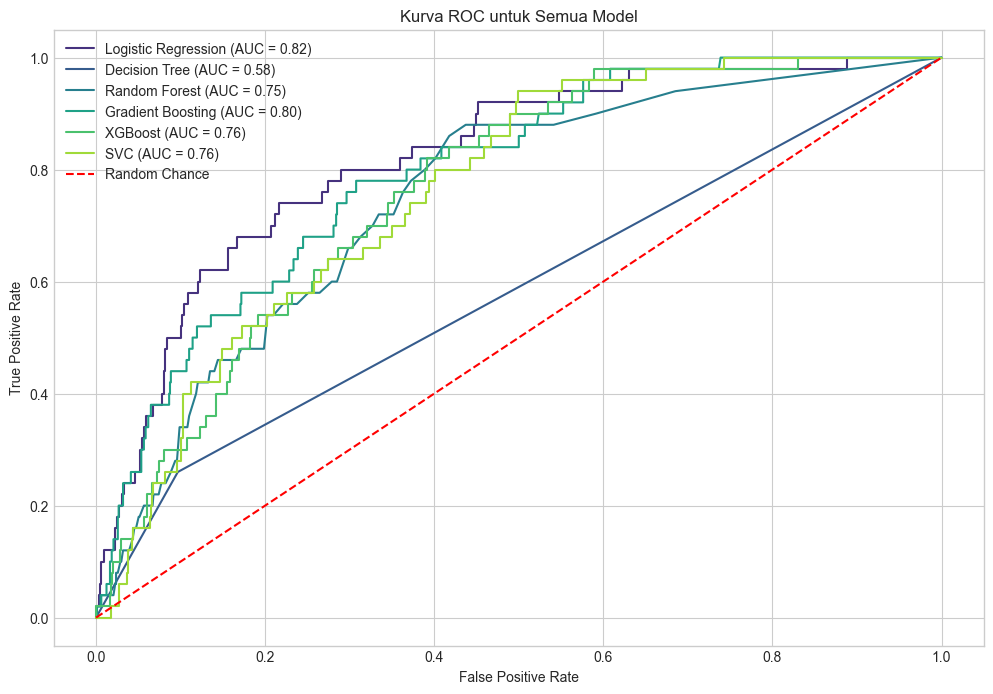

In [11]:
# 2. Kurva ROC untuk semua model
plt.figure(figsize=(12, 8))
for name, res in results.items():
    model = res['Model']
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = res['AUC']
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Chance')
plt.title('Kurva ROC untuk Semua Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

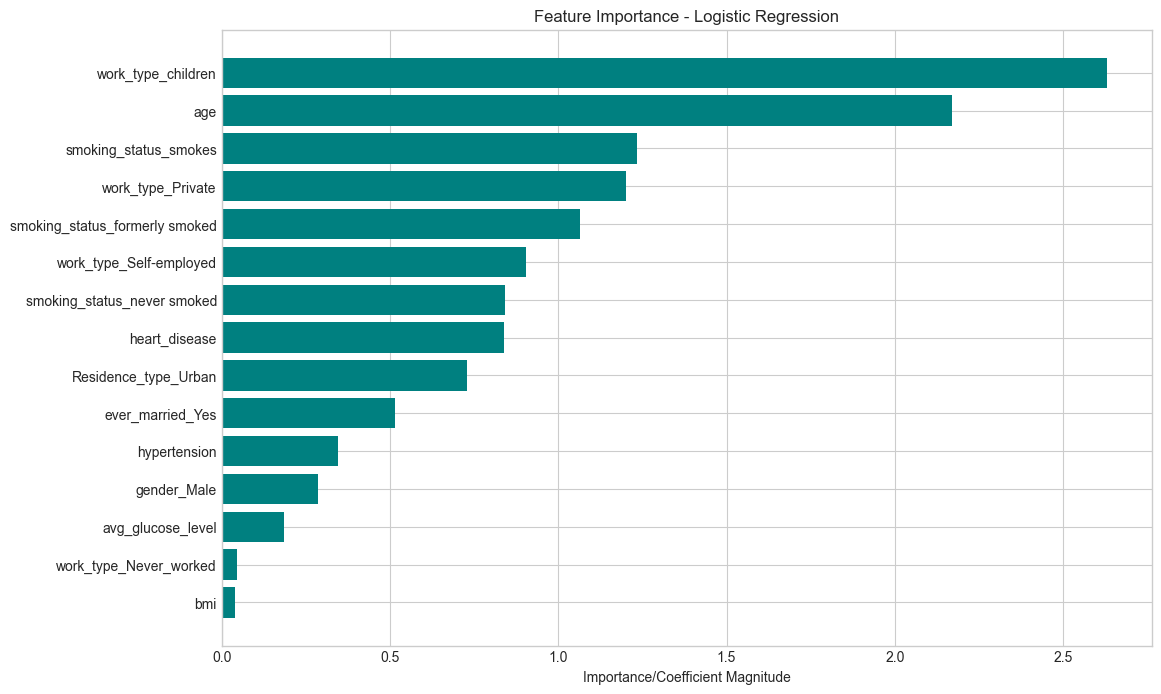

=== TOP 5 FITUR PENTING - Logistic Regression ===


,Feature,Importance
10,work_type_children,2.631869
0,age,2.168766
14,smoking_status_smokes,1.233739
8,work_type_Private,1.201301
12,smoking_status_formerly smoked,1.064382


In [12]:
# 3. Feature Importance dari model terbaik (jika tree-based) atau Koefisien (jika linear)
best_model = results[best_model_name]['Model']

if hasattr(best_model, 'feature_importances_'):
    feature_imp = pd.DataFrame(sorted(zip(best_model.feature_importances_, X.columns)), columns=['Importance', 'Feature'])
elif hasattr(best_model, 'coef_'):
    feature_imp = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(best_model.coef_[0])}).sort_values('Importance', ascending=True)
else:
    feature_imp = None

if feature_imp is not None:
    plt.figure(figsize=(12, 8))
    plt.barh(feature_imp['Feature'], feature_imp['Importance'], color='teal')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.xlabel('Importance/Coefficient Magnitude')
    plt.show()
    
    print(f"=== TOP 5 FITUR PENTING - {best_model_name} ===")
    display(feature_imp.sort_values(by='Importance', ascending=False).head())
else:
    print(f"⚠️ Model terbaik ({best_model_name}) tidak memiliki atribut 'feature_importances_' atau 'coef_'")

## 7. Kesimpulan dan Rekomendasi

In [13]:
# Kesimpulan
best_model_info = results[best_model_name]
y_pred_best = best_model_info['Model'].predict(X_test)
cm_best = confusion_matrix(y_test, y_pred_best)
tn, fp, fn, tp = cm_best.ravel()

print("=== KESIMPULAN AKHIR ===")
print(f"Project ini berhasil membangun dan mengevaluasi beberapa model machine learning untuk memprediksi risiko stroke. Tantangan utama, yaitu ketidakseimbangan kelas, telah ditangani menggunakan teknik oversampling SMOTE.")
print(f"\n🏆 Model dengan performa terbaik pada test set adalah **{best_model_name}**.")
print("--------------------------------------------------------------------------")
print(f"📊 Metrik Kunci:")
print(f"  - **AUC Score**: {best_auc:.4f}, menunjukkan kemampuan model yang baik dalam membedakan antara pasien berisiko dan tidak berisiko.")
print(f"  - **F1-Score (kelas Stroke)**: {best_f1:.4f}, mengindikasikan keseimbangan yang baik antara presisi dan recall untuk mendeteksi kasus stroke.")
print(f"  - **Akurasi**: {best_model_info['Accuracy']:.4f}, performa keseluruhan model.")

print(f"\n🧠 Analisis Prediksi:")
print(f"  - Dari {tp+fn} kasus stroke aktual di test set, model berhasil mendeteksi **{tp}** kasus (True Positives).")
print(f"  - Namun, model masih melewatkan **{fn}** kasus stroke (False Negatives), yang merupakan area kritis untuk perbaikan di masa depan.")
print(f"  - Model salah mengklasifikasikan **{fp}** pasien sehat sebagai berisiko stroke (False Positives).")

print("\n🔑 Fitur Paling Berpengaruh (berdasarkan model terbaik):")
if feature_imp is not None:
    top_feature_list = feature_imp.sort_values(by='Importance', ascending=False)['Feature'].head(3).tolist()
    print(f"  - Fitur seperti **{', '.join(top_feature_list)}** terbukti menjadi prediktor paling kuat.")
else:
    print("  - Analisis feature importance tidak tersedia untuk model ini.")

print("\n🚀 Rekomendasi Selanjutnya:")
print("  1. **Hyperparameter Tuning**: Lakukan tuning lebih dalam pada model terbaik (misalnya dengan GridSearchCV atau RandomizedSearchCV) untuk mengoptimalkan performa.")
print("  2. **Pengumpulan Data**: Menambah jumlah data, terutama untuk kelas minoritas (stroke), akan sangat meningkatkan kualitas model.")
print("  3. **Ensemble Methods**: Menggabungkan prediksi dari beberapa model terbaik untuk menciptakan model yang lebih robust.")
print("  4. **Interpretasi Model**: Gunakan teknik seperti SHAP (SHapley Additive exPlanations) untuk memahami bagaimana setiap fitur mempengaruhi prediksi secara individual.")

=== KESIMPULAN AKHIR ===
Project ini berhasil membangun dan mengevaluasi beberapa model machine learning untuk memprediksi risiko stroke. Tantangan utama, yaitu ketidakseimbangan kelas, telah ditangani menggunakan teknik oversampling SMOTE.

🏆 Model dengan performa terbaik pada test set adalah **Logistic Regression**.
--------------------------------------------------------------------------
📊 Metrik Kunci:
  - **AUC Score**: 0.8225, menunjukkan kemampuan model yang baik dalam membedakan antara pasien berisiko dan tidak berisiko.
  - **F1-Score (kelas Stroke)**: 0.2327, mengindikasikan keseimbangan yang baik antara presisi dan recall untuk mendeteksi kasus stroke.
  - **Akurasi**: 0.7613, performa keseluruhan model.

🧠 Analisis Prediksi:
  - Dari 50 kasus stroke aktual di test set, model berhasil mendeteksi **37** kasus (True Positives).
  - Namun, model masih melewatkan **13** kasus stroke (False Negatives), yang merupakan area kritis untuk perbaikan di masa depan.
  - Model salah men